# Análise Exploratória do Corpus 'Viés'

Esta análise tem como objetivo verificar o balanceamento do corpus em relação às entides abordadas, aos sentimentos atribuídos e aos veículos utilizados.

## Realizando análises exploratórias preliminares
O corpus se encontra armazenado num banco de dados MySQL, no banco CORPUS_VIES, tabelas PARAGRAPHS e NEWS

In [1]:
%matplotlib notebook

import nltk
import pymysql, traceback
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import defaultdict

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x()+rect.get_width()/2., 1.0*height, '%d'%int(height),
                ha='center', va='bottom')
        
def plotResultsInBarChart():
    pass

### Distribuição das entidades
Consulta a tabela PARAGRAPHS para cada entidade. Essa análise serve para avaliar como esse dataset está balanceado em relação aos candidatos a presidencia e ao governo de SP. Por enquanto, vou fazer somente a análise dos candidatos a presidência. Os resultados serão exibidos num gráficos de barras.

#### Consulta no banco de dados

In [2]:
presidencialCandidates = ['dilma', 'aécio neves', 'marina', 'eduardo campos', 'luciana genro']
queryResults = defaultdict(lambda: (int, []))
sqlQueryModel = 'SELECT TEXT_SOURCE, POLARITY FROM PARAGRAPHS WHERE ENTITY = "{}"'

db = pymysql.connect('localhost', 'root', '12345', 'CORPUS_VIES')
cursor = db.cursor()

for candidate in presidencialCandidates:
    sql = sqlQueryModel.format(candidate)
    try:
        cursor.execute(sql)
        results = cursor.fetchall()
        rowCount = cursor.rowcount
        queryResults[candidate] = (rowCount, results)
        
    except:
        print(traceback.format_exc())        
db.close()

#### Exibição das contagens num gráfico - Candidato x frequencia

<IPython.core.display.Javascript object>


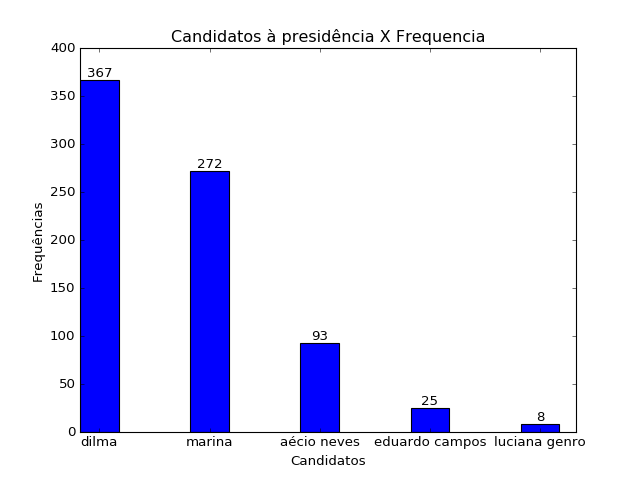

In [3]:
values = list(count for count, register in queryResults.values())
xlabels = list(queryResults.keys())
indices = np.arange(len(xlabels))

f1 = plt.figure()
ax1 = f1.add_subplot(111)

barWidth = 0.35
p = ax1.bar(indices, values, barWidth, tick_label = values)
plt.ylabel('Frequências')
plt.xlabel('Candidatos')
plt.title('Candidatos à presidência X Frequencia')
plt.xticks(indices + barWidth/2., xlabels)
autolabel(p)

plt.show()

### Distribuição das polaridades pelos candidatos

<IPython.core.display.Javascript object>


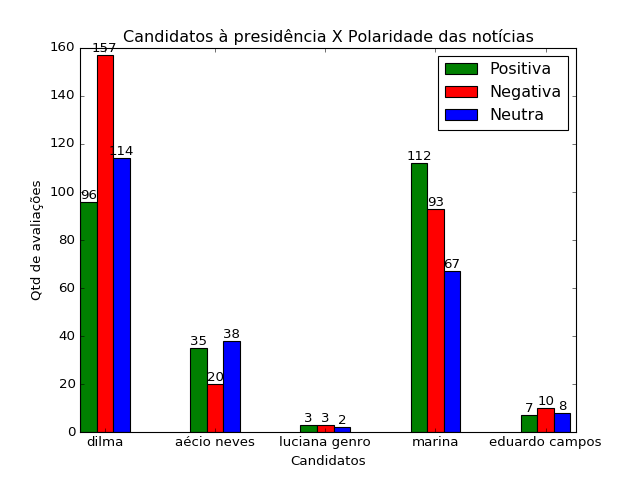

In [4]:
def countByPolarity(results):
    p = {'PO':0, 'NG':0, 'NE': 0}
    for polarity in results:
        p[polarity] += 1
    return p

def plotPolarityBar(ax, indices, polarityValues, color, offset):
    width=0.15
    p = ax.bar(indices + offset*width, polarityValues, width, color = color)
    return p

candidatesPolarities = defaultdict(lambda: {})
for candidate in presidencialCandidates:
    polarityList = [line[1] for line in queryResults[candidate][1]]
    candidatesPolarities[candidate] = countByPolarity(polarityList)
    
indices = np.arange(len(candidatesPolarities.keys()))

positiveValues = [candidatesPolarities[candidate]['PO'] for candidate in candidatesPolarities.keys()]
negativeValues = [candidatesPolarities[candidate]['NG'] for candidate in candidatesPolarities.keys()]
neutralValues = [candidatesPolarities[candidate]['NE'] for candidate in candidatesPolarities.keys()]

f2 = plt.figure()
ax2 = f2.add_subplot(111)

posivite_plot = plotPolarityBar(ax2, indices, positiveValues, 'g', offset = 0)
negative_plot = plotPolarityBar(ax2, indices, negativeValues, 'r', offset = 1)
neutral_plot =  plotPolarityBar(ax2, indices, neutralValues, 'b', offset = 2)

plt.ylabel('Qtd de avaliações')
plt.xlabel('Candidatos')
plt.title('Candidatos à presidência X Polaridade das notícias')
barWidth = 0.15
plt.xticks(indices + 3*barWidth/2., list(candidatesPolarities.keys()))
plt.legend((posivite_plot[0], negative_plot[0], neutral_plot[0]), ('Positiva', 'Negativa', 'Neutra'))

autolabel(posivite_plot)
autolabel(negative_plot)
autolabel(neutral_plot)

df = pd.DataFrame(candidatesPolarities)
df = df.transpose()
df

plt.show()

### Distribuição de veículos

In [24]:
textSources = ['@g1politica', '@folha_poder', '@VEJA', '@cartacapital', '@EstadaoPolitica']

sqlQuery = 'SELECT POLARITY FROM PARAGRAPHS WHERE TEXT_SOURCE = "{}"'
db = pymysql.connect('localhost', 'root', '12345', 'CORPUS_VIES')
cursor = db.cursor()

sourceCount = pd.DataFrame(index = textSources, columns = ['count'])


for source in textSources:
    sql = sqlQuery.format(source)
    try:
        cursor.execute(sql)
        count = cursor.rowcount
        results = cursor.fetchall()
        results = [value for value in results if value[0] != '']
        sourceCount.set_value(source, 'count', len(results))
    except:
        print(traceback.format_exc())
        
db.close()
        
sourceCount

,count
@g1politica,218
@folha_poder,596
@VEJA,114
@cartacapital,76
@EstadaoPolitica,38


### Distribuição de polaridades por candidatos e por fonte

In [26]:
from itertools import product

polarities = ['NG', 'PO', 'NE']
textSources = ['@g1politica', '@folha_poder', '@VEJA', '@cartacapital', '@EstadaoPolitica']
presidencialCandidates = ['dilma', 'aécio neves', 'marina', 'eduardo campos', 'luciana genro']

sqlQuery = 'SELECT * FROM PARAGRAPHS WHERE TEXT_SOURCE = "{}" AND ENTITY = "{}" AND POLARITY = "{}"'

db = pymysql.connect('localhost', 'root', '12345', 'CORPUS_VIES')
cursor = db.cursor()

resultDF = pd.DataFrame(index= product(presidencialCandidates, polarities), columns = textSources)

for source, entity, polarity in product(textSources, presidencialCandidates, polarities):
    sql = sqlQuery.format(*(source, entity, polarity))
    try:
        cursor.execute(sql)
        count = cursor.rowcount
        
        resultDF.set_value((entity, polarity), source, count)
    except:
        print(traceback.format_exc())
        
db.close()

resultDF

,@g1politica,@folha_poder,@VEJA,@cartacapital,@EstadaoPolitica
"(dilma, NG)",33,71,32,9,12
"(dilma, PO)",21,64,1,9,1
"(dilma, NE)",39,50,6,15,4
"(aécio neves, NG)",3,17,0,0,0
"(aécio neves, PO)",5,24,3,0,3
"(aécio neves, NE)",3,27,5,0,3
"(marina, NG)",9,54,22,6,2
"(marina, PO)",23,62,15,7,5
"(marina, NE)",14,37,8,7,1
"(eduardo campos, NG)",1,5,4,0,0


# Adjetivos mais comuns para classe positiva

## Treinamento de um tagger para portugues

In [16]:
import nltk
from nltk.corpus import mac_morpho
from pickle import dump

size = len(mac_morpho.tagged_sents())
tagged_sents = mac_morpho.tagged_sents()

train_sents = tagged_sents[:int(size*0.9)]
test_sents = tagged_sents[int(size*0.9):]

default_tagger = nltk.DefaultTagger('NN')
unigram_tagger = nltk.UnigramTagger(train = train_sents, backoff=default_tagger)
bigram_tagger = nltk.BigramTagger(train = train_sents, backoff= unigram_tagger)
bigram_tagger.evaluate(test_sents)

f = open('tagger.pkl', 'wb')
dump(bigram_tagger, f, )

0.8064182548500128

Recuperando os arquivos com a classe positiva no banco de dados

In [51]:
def get_adjective_by_sentiment(sentiment):
    db = pymysql.connect('localhost', 'root', '12345', 'CORPUS_VIES')
    cursor = db.cursor()

    sql_statement = 'SELECT PARAGRAPH FROM PARAGRAPHS WHERE POLARITY = "%s"' %sentiment
    print(sql_statement)

    cursor.execute(sql_statement)
    print(cursor.rowcount, ' Paragraphs encountered')
    lista = cursor.fetchall()
    db.close()

    result_list = []
    for sentence in lista:
        result = bigram_tagger.tag(sentence[0].split())
        result_list += result

    fd = nltk.FreqDist([word for (word,tag) in result_list if tag[:3] == 'ADJ'])
    adj_set = set(fd.keys())
    print(len(adj_set), ' Adjectives encountered\n')
    
    return adj_set

In [52]:
adj_positivos = get_adjective_by_sentiment("PO")
adj_negativos = get_adjective_by_sentiment("NG")
adj_neutros = get_adjective_by_sentiment("NE")

SELECT PARAGRAPH FROM PARAGRAPHS WHERE POLARITY = "PO"
310  Paragraphs encountered
368  Adjectives encountered

SELECT PARAGRAPH FROM PARAGRAPHS WHERE POLARITY = "NG"
391  Paragraphs encountered
382  Adjectives encountered

SELECT PARAGRAPH FROM PARAGRAPHS WHERE POLARITY = "NE"
341  Paragraphs encountered
295  Adjectives encountered



In [55]:
pos_neg_intrs = adj_positivos.intersection(adj_negativos)
len(pos_neg_intrs)

156

In [58]:
positivo_puro = adj_positivos - pos_neg_intrs
len(positivo_puro)

212

# Aplicação do método encontrado em (Pang, 2002)

<ul>
    <li>Pegar os unigramas</li>
    <li>Pegar os Bigramas</li>
    <li>Pegar os POS Tags</li>
    <li>Pegar os Adjetivos</li>
</ul>

### Funções getters

In [2]:
import nltk
from nltk.corpus import mac_morpho

size = len(mac_morpho.tagged_sents())
tagged_sents = mac_morpho.tagged_sents()

train_sents = tagged_sents[:int(size*0.9)]
test_sents = tagged_sents[int(size*0.9):]

default_tagger = nltk.DefaultTagger('NN')
unigram_tagger = nltk.UnigramTagger(train = train_sents, backoff=default_tagger)
bigram_tagger = nltk.BigramTagger(train = train_sents, backoff= unigram_tagger)
bigram_tagger.evaluate(test_sents)

def get_data_by_sentiment(label, train_rate):
    db = pymysql.connect('localhost', 'root', '12345', 'CORPUS_VIES')
    cursor = db.cursor()

    sql_statement = 'SELECT PARAGRAPH FROM PARAGRAPHS WHERE POLARITY = "%s"' %label
    print(sql_statement)

    cursor.execute(sql_statement)
    print(cursor.rowcount, ' Paragraphs encountered')
    data = cursor.fetchall()
    db.close()

    size = int(train_rate*len(data))
    train_set, test_set = list(data[:size]), list(data[size:])
    
    return train_set, test_set

def get_unigrams(text_collection, remove_stopwords = 'no'):
    stopwords = nltk.corpus.stopwords.words('portuguese')
    
    if remove_stopwords == 'yes':
        fd = nltk.FreqDist([word for sentence in text_collection
                                for word in sentence[0].split()                          
                                if word not in stopwords])
    else: 
        fd = nltk.FreqDist([word for sentence in text_collection
                                for word in sentence[0].split()])
    
    unigrams = set(fd.keys())
    return unigrams
    

def get_bigrams(text_collection):
    bigrams = set()
    
    for sentence in text_collection:
        words = sentence[0].split()
        size = len(words)
        for k in range(1, size):
            bigrams.add((words[k], words[k-1]))
    
    return bigrams

def get_adjectives(text_collection):
    result_list = []
    for sentence in text_collection:
        result = bigram_tagger.tag(sentence[0].split())
        result_list += result

    fd = nltk.FreqDist([word for (word,tag) in result_list if tag[:3] == 'ADJ'])
    adj_set = set(fd.keys())
    print(len(adj_set), ' Adjectives encountered\n')
    
    return adj_set

### Feature extractors

In [3]:
def unigram_featurizer(sentence, unigram_set):
    unigram_feature = {}
    for unigram in unigram_set:
        unigram_feature['has %s' %unigram] = unigram in sentence.split()
        
    return unigram_feature

def bigram_featurizer(sentence, bigram_set):
    bigram_feature = {}
    words = sentence.split()
    for k in range(1, len(words)):
        bigram = tuple(words[k-1: k+1])
        bigram_feature['has %s %s' %(bigram[0], bigram[1])] = bigram in bigram_set
    
    return bigram_feature

def adjectives_featurizer(sentence, adj_set):
    adj_features = {}
    words = sentence.split()
    
    for adj in adj_set:
        adj_features['has %s' %adj] = adj in words
        
    return adj_features

def build_feature_set(data_po, data_ng, data_ne, featurizer, feature):    
    feature_set = [(featurizer(sentence[0], feature), 'PO') 
                   for sentence in data_po]
    feature_set += [(featurizer(sentence[0], feature), 'NG')
                   for sentence in data_ng]
    feature_set += [(featurizer(sentence[0], feature), 'NE')
                   for sentence in data_ne]
    
    return feature_set

def evaluate_feature_performance(train_feature_set, test_feature_set, classifier_model):
    classifier = classifier_model.train(train_feature_set)
    accuracy = nltk.classify.accuracy(classifier, test_feature_set)

    print("Achieved accuracy: ", accuracy)

### Testes

In [4]:
# Coletando os datasets
train_po, test_po = get_data_by_sentiment("PO", 0.9)
train_ng, test_ng = get_data_by_sentiment("NG", 0.9)
train_ne, test_ne = get_data_by_sentiment("NE", 0.9)

unigram_set = get_unigrams(train_po + train_ng + train_ne)
unigram_set_sw = get_unigrams(train_po + train_ng + train_ne, remove_stopwords= 'yes')
bigram_set = get_bigrams(train_po + train_ng + train_ne)
adjectives_set = get_adjectives(train_po + train_ng + train_ne)

print('\n')
print(len(unigram_set), 'Unigrams found')
print(len(unigram_set_sw), 'Unigrams sw found')
print(len(bigram_set), 'Bigrams found')
print(len(adjectives_set), 'Adjectives found')

SELECT PARAGRAPH FROM PARAGRAPHS WHERE POLARITY = "PO"
310  Paragraphs encountered
SELECT PARAGRAPH FROM PARAGRAPHS WHERE POLARITY = "NG"
391  Paragraphs encountered
SELECT PARAGRAPH FROM PARAGRAPHS WHERE POLARITY = "NE"
341  Paragraphs encountered
585  Adjectives encountered



6533 Unigrams found
6385 Unigrams sw found
25886 Bigrams found
585 Adjectives found


**Features
unigramas**

In [ ]:
train_feature_set = build_feature_set(train_po, train_ng, train_ne, unigram_featurizer, unigram_set)
test_feature_set = build_feature_set(test_po, test_ng, test_ne, unigram_featurizer, unigram_set)

# evaluate_feature_performance(train_feature_set, test_feature_set, nltk.NaiveBayesClassifier)

In [7]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB([list(f.values()) for (f, c) in train_feature_set],[[c for (f, c) in train_feature_set]])
mnb.score([list(f.values()) for (f, c) in test_feature_set],[[c for (f, c) in test_feature_set]])

NotFittedError: This MultinomialNB instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [9]:
from nltk.classify import SklearnClassifier
from sklearn.svm import SVC

evaluate_feature_performance(train_feature_set, test_feature_set, SklearnClassifier(SVC(), sparse = False))

Achieved accuracy:  0.37735849056603776


In [174]:
evaluate_feature_performance(train_feature_set, test_feature_set, nltk.DecisionTreeClassifier)

Achieved accuracy:  0.41509433962264153


In [176]:
evaluate_feature_performance(train_feature_set, test_feature_set, nltk.MaxentClassifier)

  ==> Training (100 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -1.09861        0.298
         Final               nan        0.327
Achieved accuracy:  0.330188679245283


**Removendo as stopwords para ver se alcanço um desempenho melhor**

In [154]:
train_feature_set = build_feature_set(train_po, train_ng, train_ne, unigram_featurizer, unigram_set_sw)
test_feature_set = build_feature_set(test_po, test_ng, test_ne, unigram_featurizer, unigram_set_sw)

evaluate_feature_performance(train_feature_set, test_feature_set, nltk.NaiveBayesClassifier)

Achieved accuracy:  0.6320754716981132


**Features Bigrams**

In [11]:
train_feature_set = build_feature_set(train_po, train_ng, train_ne, bigram_featurizer, bigram_set)
test_feature_set = build_feature_set(test_po, test_ng, test_ne, bigram_featurizer, bigram_set)

# evaluate_feature_performance(train_feature_set, test_feature_set, nltk.NaiveBayesClassifier)

In [12]:
from nltk.classify import SklearnClassifier
from sklearn.svm import SVC

evaluate_feature_performance(train_feature_set, test_feature_set, SklearnClassifier(SVC(), sparse = False))

Achieved accuracy:  0.37735849056603776


**Features Adjetivos**

In [182]:
train_feature_set = build_feature_set(train_po, train_ng, train_ne, adjectives_featurizer, adjectives_set)
test_feature_set = build_feature_set(test_po, test_ng, test_ne, adjectives_featurizer, adjectives_set)

evaluate_feature_performance(train_feature_set, test_feature_set, nltk.NaiveBayesClassifier)

Achieved accuracy:  0.46226415094339623


In [ ]:
evaluate_feature_performance(train_feature_set, test_feature_set, nltk.DecisionTreeClassifier)

In [180]:
evaluate_feature_performance(train_feature_set, test_feature_set, nltk.MaxentClassifier)

  ==> Training (100 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -1.09861        0.298
             2          -0.94722        0.604
             3          -0.82841        0.604
             4          -0.74364        0.604
             5          -0.68327        0.604
             6          -0.63952        0.604
             7          -0.60740        0.604
             8          -0.58371        0.604
             9          -0.56626        0.604
            10          -0.55346        0.604
            11          -0.54413        0.604
            12          -0.53736        0.604
            13          -0.53247        0.604
            14          -0.52894        0.604
            15          -0.52642        0.604
            16          -0.52461        0.604
            17          -0.52331        0.604
            18          -0.52238        0.604
            19          -0.52172        0.604
 

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
counts = cv.fit_transform("caio magno de aguiar de carvalho".split())
print(counts)

  (0, 1)	1
  (1, 4)	1
  (2, 3)	1
  (3, 0)	1
  (4, 3)	1
  (5, 2)	1
